# Basic Analysis of Diabetes Reporting: Miskey Madness?

Previously, we took a look at MIMIC-III patients reporting breast cancer and drew some fancy graphs to get a sense of what we were looking at. Today, we'll be repeating and extending that analysis for diabetes reporting.

Diabetes reporting is an interesting case because diabetes is both chronic and incurable. Once a patient has diabetes, that condition *should* be reported for every subsequent visit, whether or not it's the primary reason for the hospital admission. Thus, any single-event admissions should arouse suspicions: either the person in question only ever has one hospital visit, which is perfectly plausible, or the person in question had diabetes mis-entered into their charts while they were in hospital.

We're going to perform some basic data analysis to put ourselves in a better position to answer this question.

### Getting started and re-running last week's analysis

We're going to get started with the same libraries as for our breast cancer analysis, plus the `numpy` library for generating columns of random data.

After this, we'll load our data as before.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
import numpy as np

# all data has been de-identified.

# ignore global numpy warnings that are thrown by pandas
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
diagDF = pd.read_csv("/home/cs52700/mimiciii/DIAGNOSES_ICD.csv", index_col=0)
admitDF = pd.read_csv("/home/cs52700/mimiciii/ADMISSIONS.csv", usecols=['ROW_ID', 'HADM_ID', 'ADMITTIME'], index_col=0)
procDF = pd.read_csv("/home/cs52700/mimiciii/PROCEDURES_ICD.csv", index_col=0)
patDF  = pd.read_csv("/home/cs52700/mimiciii/PATIENTS.csv", index_col=0)
diagCodeDF = pd.read_csv("/home/cs52700/mimiciii/D_ICD_DIAGNOSES.csv", index_col=0)
procCodeDF = pd.read_csv("/home/cs52700/mimiciii/D_ICD_PROCEDURES.csv", index_col=0)
scripDF = pd.read_csv("/home/cs52700/mimiciii/PRESCRIPTIONS.csv", usecols=['ROW_ID', 'SUBJECT_ID', 'DRUG'], index_col=0)


This time, since we don't have specific codes for diabetes, we'll need to extract them from our ICD 9 codes database. For the purposes of this assignment, we'll accept any code with `diabetes` in its long title. This *may* include some non-diabetes related information, but there are many, many diabetes codes. Were this a real-life expeirment, determining which codes are relevant would best be left to a Subject Matter Expert, not a programmer.

That said, we *will* remove obvious "not diabetes" values, such as the "screen for diabetes" and "family history of diabetes".

In [3]:
diabetesCodesDF = diagCodeDF[diagCodeDF['LONG_TITLE'].str.contains('diabetes', case=False)]
diabetesCodesDF.head(500)


,ICD9_CODE,SHORT_TITLE,LONG_TITLE
ROW_ID,,,
1591,25000,DMII wo cmp nt st uncntr,Diabetes mellitus without mention of complicat...
1592,25001,DMI wo cmp nt st uncntrl,Diabetes mellitus without mention of complicat...
1593,25002,DMII wo cmp uncntrld,Diabetes mellitus without mention of complicat...
1594,25003,DMI wo cmp uncntrld,Diabetes mellitus without mention of complicat...
1595,25010,DMII keto nt st uncntrld,"Diabetes with ketoacidosis, type II or unspeci..."
1596,25011,DMI keto nt st uncntrld,"Diabetes with ketoacidosis, type I [juvenile t..."
1597,25012,DMII ketoacd uncontrold,"Diabetes with ketoacidosis, type II or unspeci..."
1598,25013,DMI ketoacd uncontrold,"Diabetes with ketoacidosis, type I [juvenile t..."
1599,25020,DMII hprsm nt st uncntrl,"Diabetes with hyperosmolarity, type II or unsp..."


Now that we have a dataframe that contains all our diabetes-related codes, we can use that to isolate our diabetes patients. A repeat of last week's breast cancer analysis follows, this time for diabetes-related codes. 

We won't dive deep on this part, as it's already well covered in our previous exercise.

In [4]:
diabetesCodesDF = diabetesCodesDF[diabetesCodesDF['ICD9_CODE'] != 'V771']
diabetesCodesDF = diabetesCodesDF[diabetesCodesDF['ICD9_CODE'] != 'V180']
diabetesCodesDF = diabetesCodesDF[diabetesCodesDF['ICD9_CODE'] != 'V1221']

diabetesDF = diagDF[diagDF['ICD9_CODE'].isin(diabetesCodesDF['ICD9_CODE'])]

diabetesDF = pd.merge(diabetesDF, admitDF, on='HADM_ID')

diabetesDF['ADMITTIME'] = diabetesDF['ADMITTIME'].astype('datetime64[ns]')

diabetesDF.head()


,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ADMITTIME
0,117,140784,9.0,25000,2133-04-07 16:29:00
1,117,164853,20.0,25000,2133-11-13 21:34:00
2,123,195632,4.0,25000,2161-10-29 02:27:00
3,130,113323,7.0,25000,2119-11-14 12:00:00
4,130,198214,5.0,25060,2119-10-29 14:49:00


In [5]:
procDF['ICD9_CODE'] = procDF['ICD9_CODE'].astype('str')
procDF.head()


,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
ROW_ID,,,,
944,62641,154460,3,3404
945,2592,130856,1,9671
946,2592,130856,2,3893
947,55357,119355,1,9672
948,55357,119355,2,331


In [6]:
procCodeDF['ICD9_CODE'] = procCodeDF['ICD9_CODE'].astype('str')
procCodeDF.head()


,ICD9_CODE,SHORT_TITLE,LONG_TITLE
ROW_ID,,,
264,851,Canthotomy,Canthotomy
265,852,Blepharorrhaphy,Blepharorrhaphy
266,859,Adjust lid position NEC,Other adjustment of lid position
267,861,Lid reconst w skin graft,Reconstruction of eyelid with skin flap or graft
268,862,Lid reconst w muc graft,Reconstruction of eyelid with mucous membrane ...


In [7]:
patDF['DOB'] = patDF['DOB'].astype('datetime64[ns]')

patDF.head()

,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
ROW_ID,,,,,,,
234,249,F,2075-03-13,NaN,NaN,NaN,0
235,250,F,2164-12-27,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
236,251,M,2090-03-15,NaN,NaN,NaN,0
237,252,M,2078-03-06,NaN,NaN,NaN,0
238,253,F,2089-11-26,NaN,NaN,NaN,0


In [8]:
scripDF = scripDF[['SUBJECT_ID', 'DRUG']]
scripDF.head()

,SUBJECT_ID,DRUG
ROW_ID,,
2214776,6,Tacrolimus
2214775,6,Warfarin
2215524,6,Heparin Sodium
2216265,6,D5W
2214773,6,Furosemide


In [9]:
mergeDF = pd.merge(diabetesDF, patDF, on='SUBJECT_ID')
mergeDF['EVENT_AGE'] = mergeDF['ADMITTIME'] - mergeDF['DOB']
mergeDF['EVENT_AGE'] = mergeDF['EVENT_AGE'].astype('str')
mergeDF['EVENT_AGE'] = mergeDF['EVENT_AGE'].str.split(" ", 1, expand=True)
mergeDF['EVENT_AGE'] = mergeDF['EVENT_AGE'].astype('float')
mergeDF['EVENT_AGE'] = mergeDF['EVENT_AGE'] / 365.25
mergeDF['EVENT_AGE'] = mergeDF['EVENT_AGE'].astype('int')


mergeDF.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ADMITTIME,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,EVENT_AGE
0,117,140784,9.0,25000,2133-04-07 16:29:00,F,2083-12-28,2133-12-01 00:00:00,2133-12-01 00:00:00,2133-12-01 00:00:00,1,49
1,117,164853,20.0,25000,2133-11-13 21:34:00,F,2083-12-28,2133-12-01 00:00:00,2133-12-01 00:00:00,2133-12-01 00:00:00,1,49
2,123,195632,4.0,25000,2161-10-29 02:27:00,M,2105-08-31,NaN,NaN,NaN,0,56
3,130,113323,7.0,25000,2119-11-14 12:00:00,M,2058-06-03,2120-04-15 00:00:00,2120-04-15 00:00:00,NaN,1,61
4,130,198214,5.0,25060,2119-10-29 14:49:00,M,2058-06-03,2120-04-15 00:00:00,2120-04-15 00:00:00,NaN,1,61


In [10]:
ageDF = mergeDF[['SUBJECT_ID', 'EVENT_AGE']]
ageDF = ageDF.drop_duplicates()
ageDF = ageDF.groupby(['SUBJECT_ID'], as_index=False).min()
ageDF = ageDF.groupby(['EVENT_AGE'], as_index=False).count()

ageDF.head()

,EVENT_AGE,SUBJECT_ID
0,-284,415
1,-283,1
2,-282,5
3,-281,3
4,-278,1


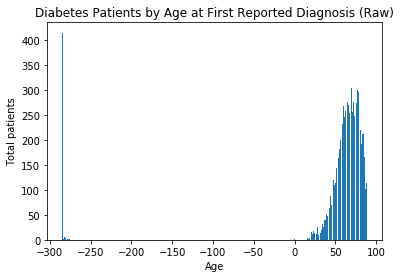

In [11]:
plt.title("Diabetes Patients by Age at First Reported Diagnosis (Raw)")
plt.xlabel("Age")
plt.ylabel("Total patients")
plt.bar(ageDF['EVENT_AGE'], ageDF['SUBJECT_ID'])
plt.rcParams['figure.figsize'] = [16, 10]
plt.show()

# Jupyter bug: you need to manually re-run this plot after running the full notebook to make it the right size.
# Sorry.

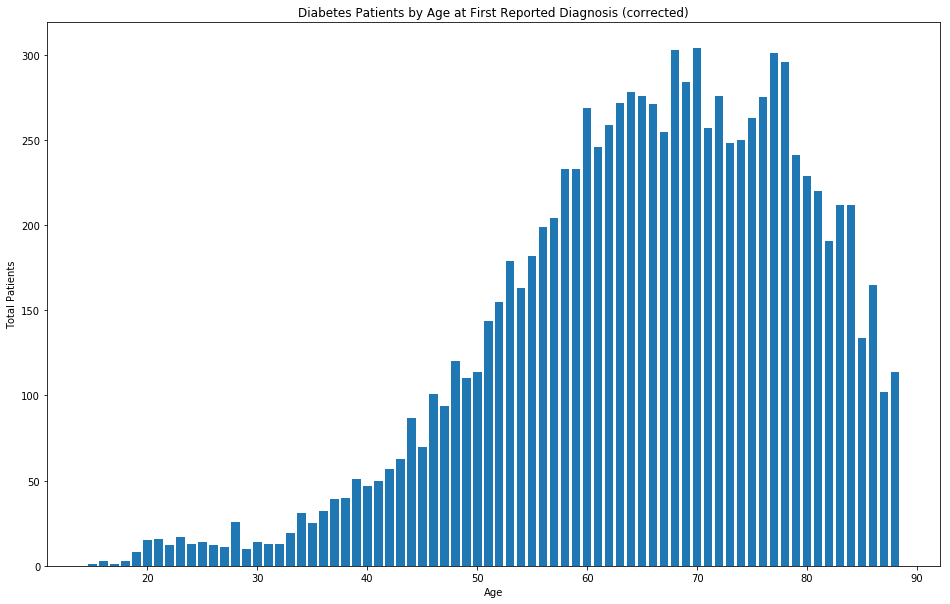

In [12]:
corAgeDF = ageDF[ageDF['EVENT_AGE'] > 0];

corAgeDF.head()

plt.title("Diabetes Patients by Age at First Reported Diagnosis (corrected)")
plt.xlabel("Age")
plt.ylabel("Total Patients")
plt.bar(corAgeDF['EVENT_AGE'], corAgeDF['SUBJECT_ID'])
plt.rcParams['figure.figsize'] = [16, 10]
plt.show()

In [13]:
diabetesPatientsDF = mergeDF[['SUBJECT_ID']]
diabetesPatientsDF = diabetesPatientsDF.drop_duplicates()

bcConditionsDF = pd.merge(diabetesPatientsDF, diagDF, on='SUBJECT_ID')
bcConditionsDF = bcConditionsDF[['ICD9_CODE', 'SUBJECT_ID']]


bcConditionsDF = bcConditionsDF[~bcConditionsDF['ICD9_CODE'].isin(diabetesCodesDF['ICD9_CODE'])]
bcConditionsDF = bcConditionsDF.groupby(['ICD9_CODE'], as_index=False).count()
bcConditionsDF = bcConditionsDF.sort_values(by=['SUBJECT_ID'], ascending=False)
bcConditionsDF = bcConditionsDF.head(10)

bcConditionDefinitionsDF = pd.merge(bcConditionsDF, diagCodeDF, on='ICD9_CODE')
bcConditionDefinitionsDF = bcConditionDefinitionsDF.rename(columns={"SUBJECT_ID": "PATIENT_COUNT"})
bcConditionDefinitionsDF


,ICD9_CODE,PATIENT_COUNT,SHORT_TITLE,LONG_TITLE
0,4019,7148,Hypertension NOS,Unspecified essential hypertension
1,4280,5818,CHF NOS,"Congestive heart failure, unspecified"
2,41401,5134,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...
3,42731,4400,Atrial fibrillation,Atrial fibrillation
4,5849,3855,Acute kidney failure NOS,"Acute kidney failure, unspecified"
5,2724,3661,Hyperlipidemia NEC/NOS,Other and unspecified hyperlipidemia
6,V5867,2508,Long-term use of insulin,Long-term (current) use of insulin
7,51881,2506,Acute respiratry failure,Acute respiratory failure
8,5990,2335,Urin tract infection NOS,"Urinary tract infection, site not specified"
9,2720,2261,Pure hypercholesterolem,Pure hypercholesterolemia


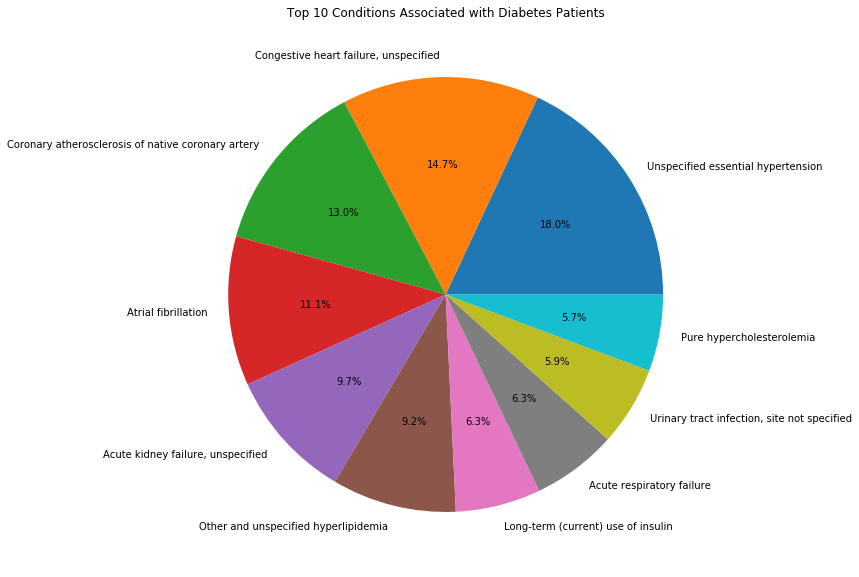

In [14]:

plt.title("Top 10 Conditions Associated with Diabetes Patients")
plt.pie(bcConditionDefinitionsDF['PATIENT_COUNT'], labels=bcConditionDefinitionsDF['LONG_TITLE'], autopct='%1.1f%%')
plt.rcParams['figure.figsize'] = [16, 10]
plt.show()

In [15]:

bcProceduresDF = pd.merge(diabetesPatientsDF, procDF, on='SUBJECT_ID')
bcProceduresDF = bcProceduresDF[['ICD9_CODE', 'SUBJECT_ID']]


bcProceduresDF = bcProceduresDF[~bcProceduresDF['ICD9_CODE'].isin(diabetesCodesDF['ICD9_CODE'])]
bcProceduresDF = bcProceduresDF.groupby(['ICD9_CODE'], as_index=False).count()
bcProceduresDF = bcProceduresDF.sort_values(by=['SUBJECT_ID'], ascending=False)
bcProceduresDF = bcProceduresDF.head(10)


bcProceduresDF = pd.merge(bcProceduresDF, procCodeDF, on='ICD9_CODE')
bcProceduresDF = bcProceduresDF.rename(columns={"SUBJECT_ID": "PATIENT_COUNT"})
bcProceduresDF.head(10)

,ICD9_CODE,PATIENT_COUNT,SHORT_TITLE,LONG_TITLE
0,3893,4982,Venous cath NEC,"Venous catheterization, not elsewhere classified"
1,9604,2716,Insert endotracheal tube,Insertion of endotracheal tube
2,966,2399,Entral infus nutrit sub,Enteral infusion of concentrated nutritional s...
3,9671,2351,Cont inv mec ven <96 hrs,Continuous invasive mechanical ventilation for...
4,9904,2322,Packed cell transfusion,Transfusion of packed cells
5,3961,2264,Extracorporeal circulat,Extracorporeal circulation auxiliary to open h...
6,8856,1957,Coronar arteriogr-2 cath,Coronary arteriography using two catheters
7,9672,1807,Cont inv mec ven 96+ hrs,Continuous invasive mechanical ventilation for...
8,3615,1801,1 int mam-cor art bypass,Single internal mammary-coronary artery bypass
9,3995,1789,Hemodialysis,Hemodialysis


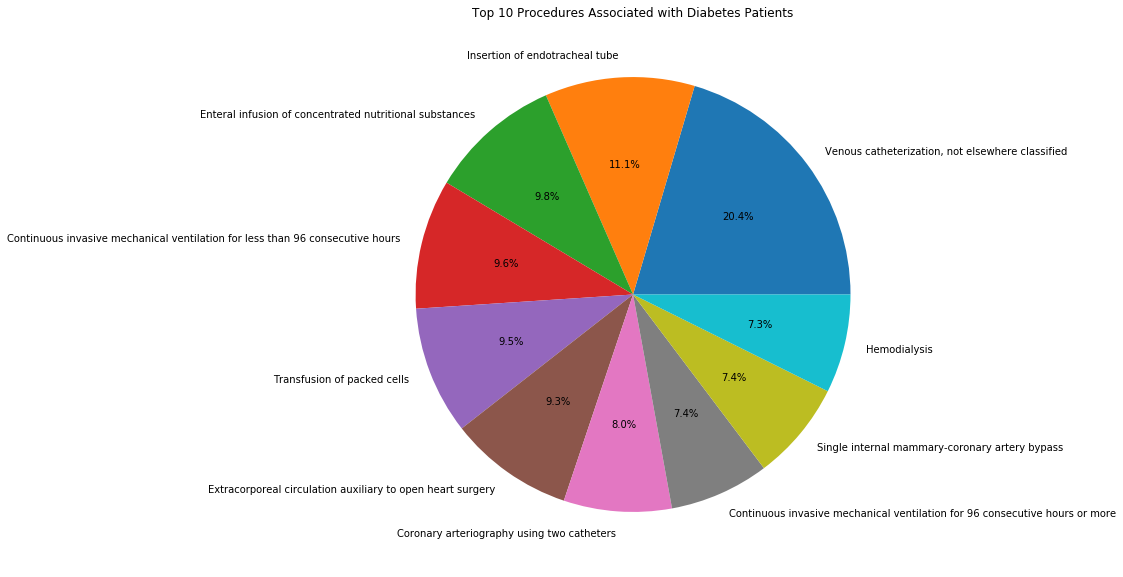

In [16]:

plt.title("Top 10 Procedures Associated with Diabetes Patients")
plt.pie(bcProceduresDF['PATIENT_COUNT'], labels=bcProceduresDF['LONG_TITLE'], autopct='%1.1f%%')
plt.rcParams['figure.figsize'] = [16, 10]
plt.show()

In [17]:

bcDrugsDF = pd.merge(diabetesPatientsDF, scripDF, on='SUBJECT_ID')
bcDrugsDF = bcDrugsDF[['SUBJECT_ID', 'DRUG']]


bcDrugsDF = bcDrugsDF.groupby(['DRUG'], as_index=False).count()
bcDrugsDF = bcDrugsDF.sort_values(by=['SUBJECT_ID'], ascending=False)
bcDrugsDF = bcDrugsDF.head(10)


bcDrugsDF = bcDrugsDF.rename(columns={"SUBJECT_ID": "PATIENT_COUNT"})
bcDrugsDF.head(10)

,DRUG,PATIENT_COUNT
1191,Insulin,107004
1925,Potassium Chloride,57615
970,Furosemide,50421
654,D5W,47082
1642,NS,41460
52,0.9% Sodium Chloride,40467
1233,Iso-Osmotic Dextrose,30040
1444,Magnesium Sulfate,27786
2140,Sodium Chloride 0.9% Flush,26599
62,5% Dextrose,25684


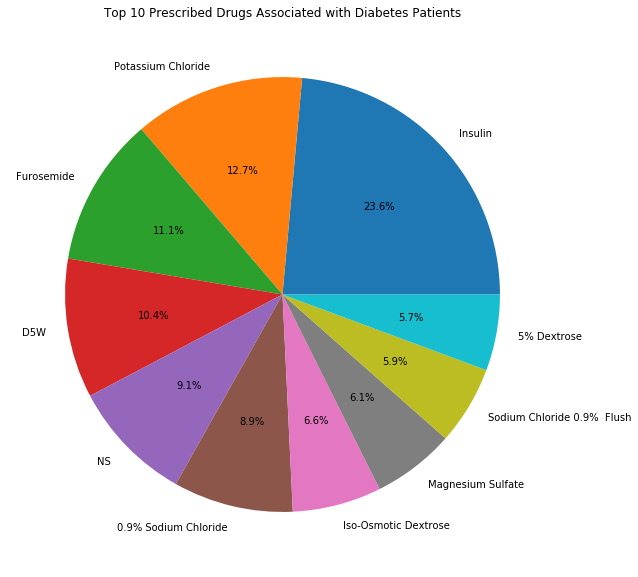

In [18]:

plt.title("Top 10 Prescribed Drugs Associated with Diabetes Patients")
plt.pie(bcDrugsDF['PATIENT_COUNT'], labels=bcDrugsDF['DRUG'], autopct='%1.1f%%')
plt.rcParams['figure.figsize'] = [16, 10]
plt.show()

Of note: unlike the "salt, sugar, and water" results we got for breast cancer, insulin shows up as drug number one for diabetes, surprising nobody in the audience!

This week, we want to go a bit further with our data. We'll start with mergeDF, our data frame that isolates every diabetes-related visit for every patient.

In order to stratify these results into "real diabetes patients" and "probably not diabetes patients", we'll do a total count of the number of diabetes visits for each patent:

In [19]:
diabetesPatientTotalVisitsDF = mergeDF[['SUBJECT_ID', 'HADM_ID']].groupby(['SUBJECT_ID'], as_index=False).count().sort_values(by=['HADM_ID'], ascending=False)
diabetesPatientTotalVisitsDF.head()

,SUBJECT_ID,HADM_ID
3486,19213,78
4286,23657,74
2359,13033,68
1425,7809,64
2131,11861,56


This gives us a sorted list of `SUBJECT_ID`s, ranked by a descending count of unique `HADM_ID`s. We can use this as the starting point for our graph.

To make graphing easier, we'll introduce a new column, `Y_VALUE`, that will match a `SUBJECT_ID` on a one-to-one basis. When plotting, we'll use `Y_VALUE` exactly as you'd expect, as the y-value for our plot coordinates. This will create an individual "row" for each patient.

In [20]:
diabetesPatientTotalVisitsDF['Y_VALUE'] = range(0, len(diabetesPatientTotalVisitsDF))
diabetesPatientTotalVisitsDF = diabetesPatientTotalVisitsDF.rename(columns={"HADM_ID": "VISIT_COUNT"})

diabetesPatientTotalVisitsDF.head(50)

,SUBJECT_ID,VISIT_COUNT,Y_VALUE
3486,19213,78,0
4286,23657,74,1
2359,13033,68,2
1425,7809,64,3
2131,11861,56,4
4532,24995,45,5
5358,29035,42,6
10247,96686,38,7
3324,18353,37,8
1585,8799,36,9


Now, we can merge this table with our `mergeDF` dataframe to create a dataframe that includes a y-value for plotting individual patients:

In [21]:
diabetesVisitsWithY = pd.merge(diabetesPatientTotalVisitsDF, mergeDF, on='SUBJECT_ID')
diabetesVisitsWithY.head(100)

,SUBJECT_ID,VISIT_COUNT,Y_VALUE,HADM_ID,SEQ_NUM,ICD9_CODE,ADMITTIME,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,EVENT_AGE
0,19213,78,0,114282,3.0,25061,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35
1,19213,78,0,114282,4.0,25041,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35
2,19213,78,0,114282,5.0,25051,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35
3,19213,78,0,114282,6.0,25011,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35
4,19213,78,0,116506,1.0,25011,2203-03-22 12:40:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,34
5,19213,78,0,116506,8.0,25061,2203-03-22 12:40:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,34
6,19213,78,0,116506,9.0,25041,2203-03-22 12:40:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,34
7,19213,78,0,117054,1.0,25011,2203-09-21 09:57:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,34
8,19213,78,0,117054,7.0,25041,2203-09-21 09:57:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,34
9,19213,78,0,117054,8.0,25051,2203-09-21 09:57:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,34


One more thing before we hit go: let's add some *jitter* to our plot. Jitter is simply a little bit of randomness tagged to a value to help ensure that repeated plots on the same area get noticed. Since we have a generated age column that's an integer–and since plotting based on age is going to give us results that line up in a meaningful fashion–we'll create an `AGE_JITTER` column that's simply `AGE` plus a random value between `-0.5` and `0.5`.

This will result in a graph that's *technically* inaccurate but *practically* far more informative.

In [22]:
diabetesVisitsWithY['JITTER'] = np.random.rand(diabetesVisitsWithY.shape[0])
diabetesVisitsWithY['EVENT_AGE_JITTER'] = diabetesVisitsWithY['EVENT_AGE'] + diabetesVisitsWithY['JITTER'] - 0.5
diabetesVisitsWithY['EVENT_AGE_JITTER'] = diabetesVisitsWithY['EVENT_AGE_JITTER'].astype('float')
diabetesVisitsWithY.head()

,SUBJECT_ID,VISIT_COUNT,Y_VALUE,HADM_ID,SEQ_NUM,ICD9_CODE,ADMITTIME,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,EVENT_AGE,JITTER,EVENT_AGE_JITTER
0,19213,78,0,114282,3.0,25061,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35,0.214136,34.714136
1,19213,78,0,114282,4.0,25041,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35,0.213384,34.713384
2,19213,78,0,114282,5.0,25051,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35,0.194985,34.694985
3,19213,78,0,114282,6.0,25011,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35,0.440197,34.940197
4,19213,78,0,116506,1.0,25011,2203-03-22 12:40:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,34,0.599431,34.099431


OK! Moment of truth: the graphing!

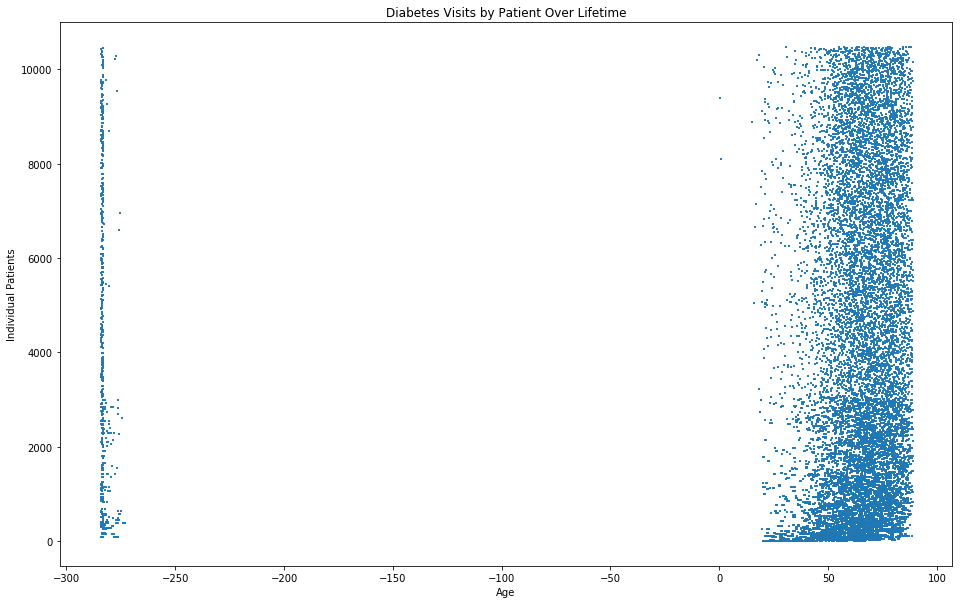

In [23]:
plt.title("Diabetes Visits by Patient Over Lifetime")
plt.xlabel("Age")
plt.ylabel("Individual Patients")
plt.scatter(diabetesVisitsWithY['EVENT_AGE_JITTER'], diabetesVisitsWithY['Y_VALUE'], marker=',', s=1)
plt.rcParams['figure.figsize'] = [16, 10]
plt.show()

...once again, we'll remove values under 0 to simplify things:

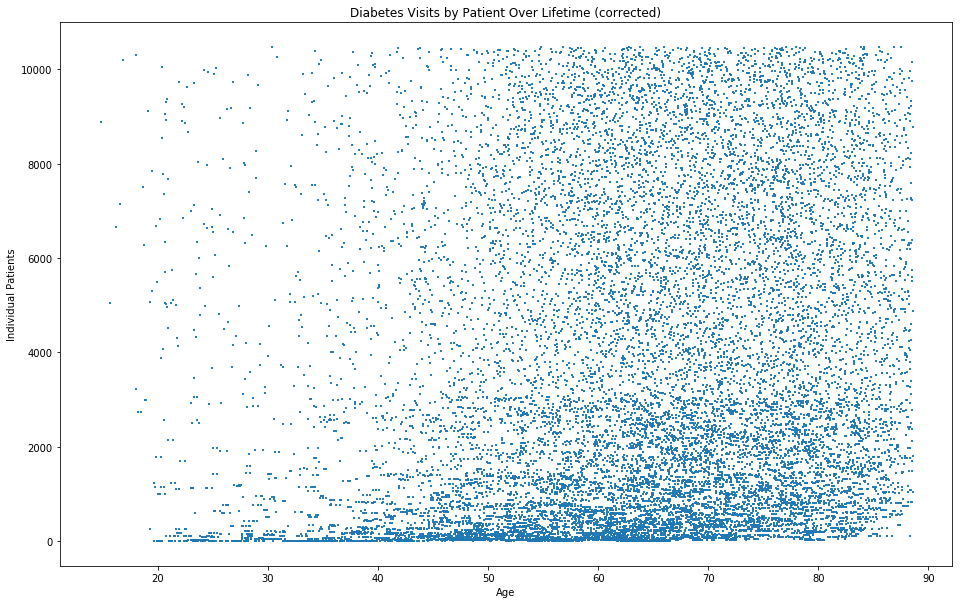

In [24]:
correctedDiabetesVisitsWithY = diabetesVisitsWithY[diabetesVisitsWithY['EVENT_AGE'] > 0];

plt.title("Diabetes Visits by Patient Over Lifetime (corrected)")
plt.xlabel("Age")
plt.ylabel("Individual Patients")
plt.scatter(correctedDiabetesVisitsWithY['EVENT_AGE_JITTER'], correctedDiabetesVisitsWithY['Y_VALUE'], marker=',', s=1)
plt.rcParams['figure.figsize'] = [16, 10]
plt.show()

This clearly shows us the events by date, but it's difficult to read, especially towards the top. There's simply too much data here for us to parse it with this design. Let's try something different.

Instead of making our x-axis the patient's age, let's make the x-axis equal to "years since first diabetes diagnosis". That way, we should be able to see the disease progression line up better, with the top of the graph being mostly plots along the X axis.



In [25]:
youngestAgeDF = mergeDF[['SUBJECT_ID', 'EVENT_AGE']]
youngestAgeDF = youngestAgeDF.drop_duplicates()
youngestAgeDF = youngestAgeDF.groupby(['SUBJECT_ID'], as_index=False).min()


youngestAgeDF = youngestAgeDF.rename(columns={"EVENT_AGE": "EVENT_YOUNGEST_AGE"})
correctedDiabetesVisitsWithY = pd.merge(correctedDiabetesVisitsWithY, youngestAgeDF, on='SUBJECT_ID')
correctedDiabetesVisitsWithY.shape

(17665, 17)

We want to update our `EVENT_AGE_JITTER` to reflect actual age minus age of first diagnosis, as well:

In [26]:
correctedDiabetesVisitsWithY['EVENT_AGE_JITTER'] = correctedDiabetesVisitsWithY['EVENT_AGE'] - correctedDiabetesVisitsWithY['EVENT_YOUNGEST_AGE'] + correctedDiabetesVisitsWithY['JITTER'] - 0.5
correctedDiabetesVisitsWithY['EVENT_AGE_JITTER'] = correctedDiabetesVisitsWithY['EVENT_AGE_JITTER'].astype('float')
correctedDiabetesVisitsWithY.shape

(17665, 17)

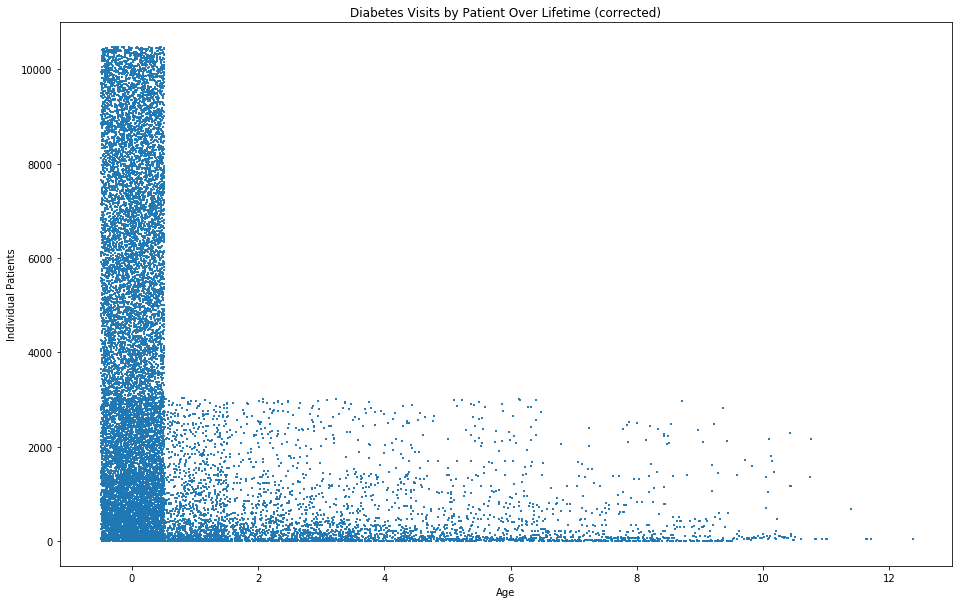

In [27]:
plt.title("Diabetes Visits by Patient Over Lifetime (corrected)")
plt.xlabel("Age")
plt.ylabel("Individual Patients")
plt.scatter(correctedDiabetesVisitsWithY['EVENT_AGE_JITTER'], correctedDiabetesVisitsWithY['Y_VALUE'], marker=',', s=1)
plt.rcParams['figure.figsize'] = [16, 10]
plt.show()

We're getting...closer? The jitter helped when we had a whole bunch of data, but it's less useful now––especially as the large column near zero is almost certainly single-visit patients. We need a better jitter modifier; fortunately, that should be fairly easy to do.

Let's take our existing `JITTER` values and make them smaller for patients with fewer events. We'll reduce `JITTER` based on a sliding scale: if a patient has 1 lifetime event, they'll have 0 jitter; 5 events, 50% jitter; 10 or more events, 100% jitter.



In [28]:
correctedDiabetesVisitsWithY['JITTER'] = np.random.rand(correctedDiabetesVisitsWithY.shape[0])
correctedDiabetesVisitsWithY['JITTER_FACTOR'] = ((correctedDiabetesVisitsWithY['VISIT_COUNT']-1) / 10).clip(0,1)
correctedDiabetesVisitsWithY['JITTER'] = correctedDiabetesVisitsWithY['JITTER'] * correctedDiabetesVisitsWithY['JITTER_FACTOR']

correctedDiabetesVisitsWithY['EVENT_AGE_JITTER'] = correctedDiabetesVisitsWithY['EVENT_AGE'] - correctedDiabetesVisitsWithY['EVENT_YOUNGEST_AGE'] + correctedDiabetesVisitsWithY['JITTER'] - 0.5
correctedDiabetesVisitsWithY['EVENT_AGE_JITTER'] = correctedDiabetesVisitsWithY['EVENT_AGE_JITTER'].astype('float')
correctedDiabetesVisitsWithY.head()

,SUBJECT_ID,VISIT_COUNT,Y_VALUE,HADM_ID,SEQ_NUM,ICD9_CODE,ADMITTIME,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,EVENT_AGE,JITTER,EVENT_AGE_JITTER,EVENT_YOUNGEST_AGE,JITTER_FACTOR
0,19213,78,0,114282,3.0,25061,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35,0.536003,4.036003,31,1.0
1,19213,78,0,114282,4.0,25041,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35,0.635036,4.135036,31,1.0
2,19213,78,0,114282,5.0,25051,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35,0.353180,3.853180,31,1.0
3,19213,78,0,114282,6.0,25011,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35,0.839725,4.339725,31,1.0
4,19213,78,0,116506,1.0,25011,2203-03-22 12:40:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,34,0.364784,2.864784,31,1.0


OK, let's run this again, this time with customized levels of jitter:

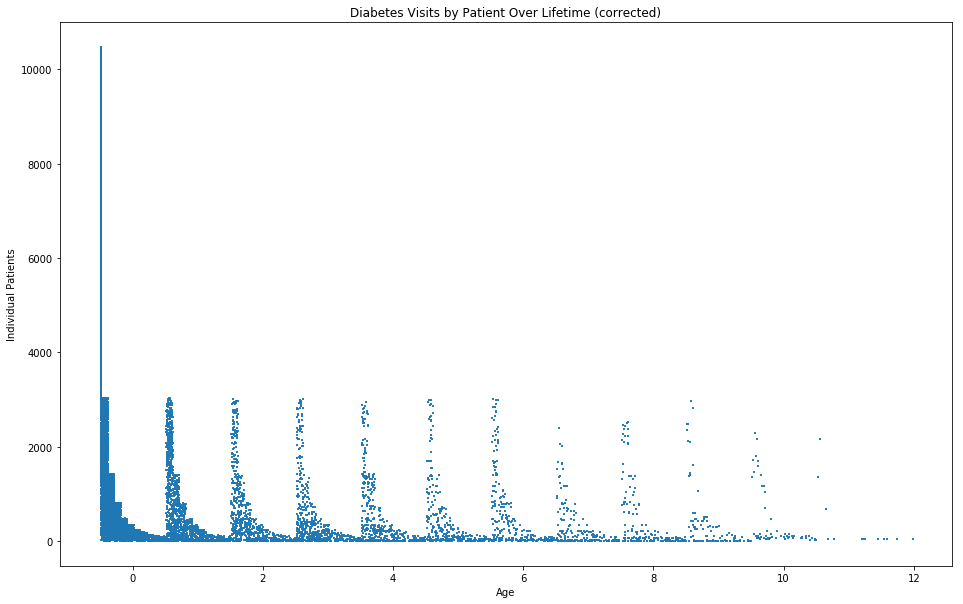

In [29]:
plt.title("Diabetes Visits by Patient Over Lifetime (corrected)")
plt.xlabel("Age")
plt.ylabel("Individual Patients")
plt.scatter(correctedDiabetesVisitsWithY['EVENT_AGE_JITTER'], correctedDiabetesVisitsWithY['Y_VALUE'], marker=',', s=1)
plt.rcParams['figure.figsize'] = [16, 10]
plt.show()

It's a tad messy–the curves suggest there's some kind of shape to the data that really isn't there–but in the end, we have a better vision of when these events are taking place.

Let's do one more pass at the jitter-adjustment, only this time we'll only remove jitter people with only one visit to their names:

In [30]:
correctedDiabetesVisitsWithY['JITTER'] = np.random.rand(correctedDiabetesVisitsWithY.shape[0])
correctedDiabetesVisitsWithY['JITTER_FACTOR'] = ((correctedDiabetesVisitsWithY['VISIT_COUNT']-1) / 1).clip(0,1)
correctedDiabetesVisitsWithY['JITTER'] = correctedDiabetesVisitsWithY['JITTER'] * correctedDiabetesVisitsWithY['JITTER_FACTOR']

correctedDiabetesVisitsWithY['EVENT_AGE_JITTER'] = correctedDiabetesVisitsWithY['EVENT_AGE'] - correctedDiabetesVisitsWithY['EVENT_YOUNGEST_AGE'] + correctedDiabetesVisitsWithY['JITTER'] - 0.5
correctedDiabetesVisitsWithY['EVENT_AGE_JITTER'] = correctedDiabetesVisitsWithY['EVENT_AGE_JITTER'].astype('float')
correctedDiabetesVisitsWithY.head()

,SUBJECT_ID,VISIT_COUNT,Y_VALUE,HADM_ID,SEQ_NUM,ICD9_CODE,ADMITTIME,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,EVENT_AGE,JITTER,EVENT_AGE_JITTER,EVENT_YOUNGEST_AGE,JITTER_FACTOR
0,19213,78,0,114282,3.0,25061,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35,0.470036,3.970036,31,1.0
1,19213,78,0,114282,4.0,25041,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35,0.467169,3.967169,31,1.0
2,19213,78,0,114282,5.0,25051,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35,0.413112,3.913112,31,1.0
3,19213,78,0,114282,6.0,25011,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35,0.817172,4.317172,31,1.0
4,19213,78,0,116506,1.0,25011,2203-03-22 12:40:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,34,0.347934,2.847934,31,1.0


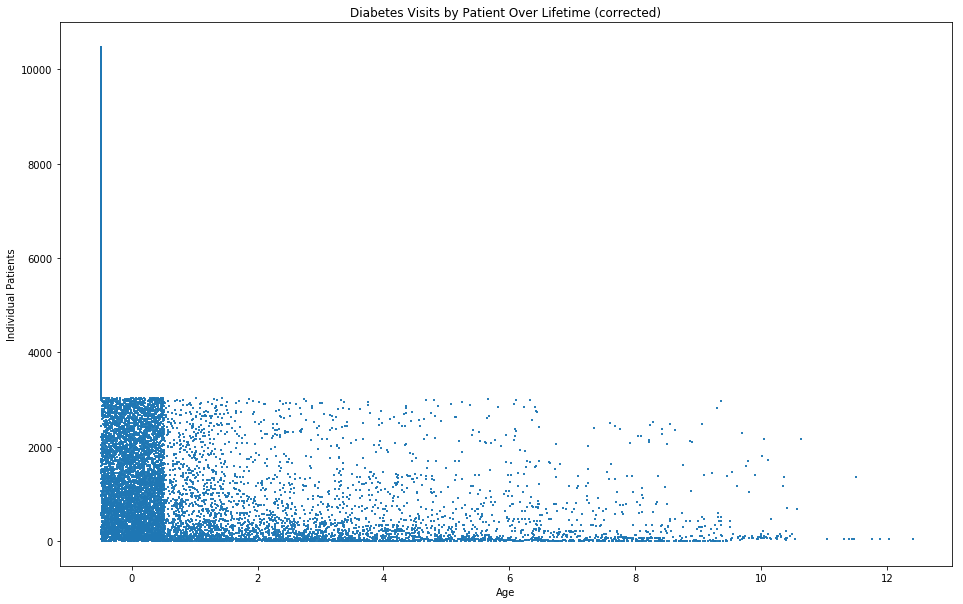

In [31]:
plt.title("Diabetes Visits by Patient Over Lifetime (corrected)")
plt.xlabel("Age")
plt.ylabel("Individual Patients")
plt.scatter(correctedDiabetesVisitsWithY['EVENT_AGE_JITTER'], correctedDiabetesVisitsWithY['Y_VALUE'], marker=',', s=1)
plt.rcParams['figure.figsize'] = [16, 10]
plt.show()

Better, but there's still that big clump of first-year visits that makes the whole thing look ugly.

Let's try it using admit times instead of a jittered year value.

In [32]:
earliestAdmitDF = mergeDF[['SUBJECT_ID', 'ADMITTIME']]
earliestAdmitDF = earliestAdmitDF.drop_duplicates()
earliestAdmitDF = earliestAdmitDF.groupby(['SUBJECT_ID'], as_index=False).min()


earliestAdmitDF = earliestAdmitDF.rename(columns={"ADMITTIME": "FIRST_ADMITTIME"})
earliestAdmitDF['FIRST_ADMITTIME'] = earliestAdmitDF['FIRST_ADMITTIME'].astype('datetime64[ns]')
correctedDiabetesVisitsWithY = pd.merge(correctedDiabetesVisitsWithY, earliestAdmitDF, on='SUBJECT_ID')
correctedDiabetesVisitsWithY.head()

,SUBJECT_ID,VISIT_COUNT,Y_VALUE,HADM_ID,SEQ_NUM,ICD9_CODE,ADMITTIME,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,EVENT_AGE,JITTER,EVENT_AGE_JITTER,EVENT_YOUNGEST_AGE,JITTER_FACTOR,FIRST_ADMITTIME
0,19213,78,0,114282,3.0,25061,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35,0.470036,3.970036,31,1.0,2200-09-02 16:09:00
1,19213,78,0,114282,4.0,25041,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35,0.467169,3.967169,31,1.0,2200-09-02 16:09:00
2,19213,78,0,114282,5.0,25051,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35,0.413112,3.913112,31,1.0,2200-09-02 16:09:00
3,19213,78,0,114282,6.0,25011,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35,0.817172,4.317172,31,1.0,2200-09-02 16:09:00
4,19213,78,0,116506,1.0,25011,2203-03-22 12:40:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,34,0.347934,2.847934,31,1.0,2200-09-02 16:09:00


In [33]:
correctedDiabetesVisitsWithY['TIME_SINCE_FIRST_ADMIT'] = correctedDiabetesVisitsWithY['ADMITTIME'] - correctedDiabetesVisitsWithY['FIRST_ADMITTIME']
correctedDiabetesVisitsWithY['TIME_SINCE_FIRST_ADMIT'] = correctedDiabetesVisitsWithY['TIME_SINCE_FIRST_ADMIT'].astype('str')
correctedDiabetesVisitsWithY['TIME_SINCE_FIRST_ADMIT'] = correctedDiabetesVisitsWithY['TIME_SINCE_FIRST_ADMIT'].str.split(" ", 1, expand=True)
correctedDiabetesVisitsWithY['TIME_SINCE_FIRST_ADMIT'] = correctedDiabetesVisitsWithY['TIME_SINCE_FIRST_ADMIT'].astype('float')
correctedDiabetesVisitsWithY['TIME_SINCE_FIRST_ADMIT'] = correctedDiabetesVisitsWithY['TIME_SINCE_FIRST_ADMIT'] / 365.25


correctedDiabetesVisitsWithY.head()

,SUBJECT_ID,VISIT_COUNT,Y_VALUE,HADM_ID,SEQ_NUM,ICD9_CODE,ADMITTIME,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,EVENT_AGE,JITTER,EVENT_AGE_JITTER,EVENT_YOUNGEST_AGE,JITTER_FACTOR,FIRST_ADMITTIME,TIME_SINCE_FIRST_ADMIT
0,19213,78,0,114282,3.0,25061,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35,0.470036,3.970036,31,1.0,2200-09-02 16:09:00,3.362081
1,19213,78,0,114282,4.0,25041,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35,0.467169,3.967169,31,1.0,2200-09-02 16:09:00,3.362081
2,19213,78,0,114282,5.0,25051,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35,0.413112,3.913112,31,1.0,2200-09-02 16:09:00,3.362081
3,19213,78,0,114282,6.0,25011,2204-01-14 01:55:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,35,0.817172,4.317172,31,1.0,2200-09-02 16:09:00,3.362081
4,19213,78,0,116506,1.0,25011,2203-03-22 12:40:00,F,2168-10-06,2206-06-20 00:00:00,NaN,2206-06-20 00:00:00,1,34,0.347934,2.847934,31,1.0,2200-09-02 16:09:00,2.546201


OK, this is something! Let's try plotting it:

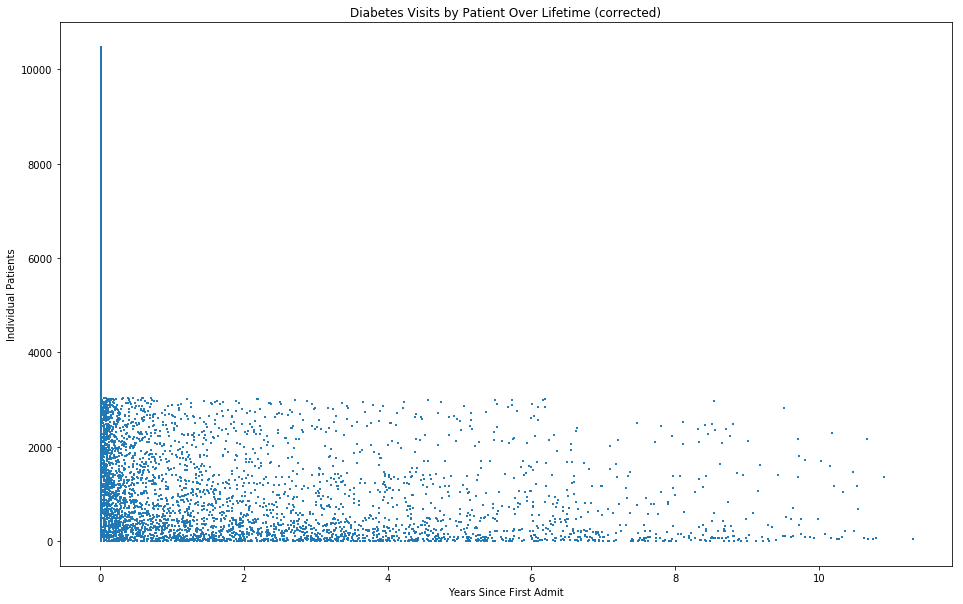

In [34]:
plt.title("Diabetes Visits by Patient Over Lifetime (corrected)")
plt.xlabel("Years Since First Admit")
plt.ylabel("Individual Patients")
plt.scatter(correctedDiabetesVisitsWithY['TIME_SINCE_FIRST_ADMIT'], correctedDiabetesVisitsWithY['Y_VALUE'], marker=',', s=1)
plt.rcParams['figure.figsize'] = [16, 10]
plt.show()

Success! Here we have a nice, accurate view of what our patient breakdown looks like. We can't assume that all the single-event diabetes patients are miskeys, and further analysis of the single-instance cases is certainly warranted. That said, single-event patients make up roughly three-quarters of the total population; if even a small proportion of these single-event patients are miskeys, we're still looking at substantial numbers of coding errors. This suggests a serious problem with miskeys in medical data.

Another category to consider: these single-admits are people who are visiting a MIMIC-III hospital as out-of-network patients. They'd only ever appear in the MIMIC-III database this one time, asssuming their "regular" hospital is one that doesn't participate in MIMIC-III.

There's a lot still to consider, but we've got a start.

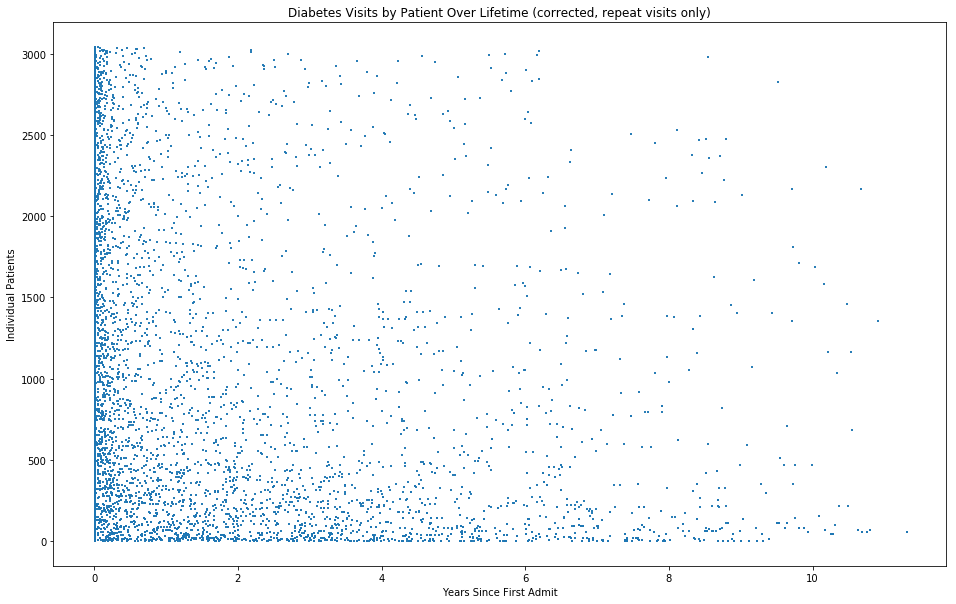

In [35]:
narrowCorrectedDiabetesVisitsWithY = correctedDiabetesVisitsWithY[correctedDiabetesVisitsWithY['VISIT_COUNT'] > 1]
plt.title("Diabetes Visits by Patient Over Lifetime (corrected, repeat visits only)")
plt.xlabel("Years Since First Admit")
plt.ylabel("Individual Patients")
plt.scatter(narrowCorrectedDiabetesVisitsWithY['TIME_SINCE_FIRST_ADMIT'], narrowCorrectedDiabetesVisitsWithY['Y_VALUE'], marker=',', s=1)
plt.rcParams['figure.figsize'] = [16, 10]
plt.show()

### Anomalies: The Disappearing Disease

Let's look into some potential anomalies. First, we want to find patients who have had a diabetes diagnosis in the past, but have *also* had a visit after their initial diabetes diagnosis where diabetes was *not* included in their ICD-9 codes.

To do this, we'll start with our big `correctedDiabetesVisitsWithY` dataframe and merge it with a to-be-created dataframe that lists the date of their *most recent* admit *without* a diabetes diagnosis. From there, we can simply find all patients whose first diabetes diagnoses happened *before* their last admit without a diabetes diagnosis.

In [36]:
lastNonDiabetesDateDF = diagDF[['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']]
lastNonDiabetesDateDF = lastNonDiabetesDateDF[~lastNonDiabetesDateDF['ICD9_CODE'].isin(diabetesCodesDF['ICD9_CODE'])]
lastNonDiabetesDateDF = lastNonDiabetesDateDF[['SUBJECT_ID', 'HADM_ID']]
lastNonDiabetesDateDF = pd.merge(lastNonDiabetesDateDF, admitDF, on="HADM_ID")
lastNonDiabetesDateDF = lastNonDiabetesDateDF[['SUBJECT_ID', 'ADMITTIME']]
lastNonDiabetesDateDF = lastNonDiabetesDateDF.rename(columns={"ADMITTIME": "LAST_NONDIABETES_TIME"})

lastNonDiabetesDateDF = lastNonDiabetesDateDF.drop_duplicates()
lastNonDiabetesDateDF = lastNonDiabetesDateDF.groupby(['SUBJECT_ID'], as_index=False).max()

lastNonDiabetesDateDF.head()

,SUBJECT_ID,LAST_NONDIABETES_TIME
0,2,2138-07-17 19:04:00
1,3,2101-10-20 19:08:00
2,4,2191-03-16 00:28:00
3,5,2103-02-02 04:31:00
4,6,2175-05-30 07:15:00


In [37]:
compareDiabetesDatesDF = pd.merge(lastNonDiabetesDateDF, correctedDiabetesVisitsWithY, on='SUBJECT_ID')
compareDiabetesDatesDF['LAST_NONDIABETES_TIME'] = compareDiabetesDatesDF['LAST_NONDIABETES_TIME'].astype('datetime64[ns]')

compareDiabetesDatesDF.head()

,SUBJECT_ID,LAST_NONDIABETES_TIME,VISIT_COUNT,Y_VALUE,HADM_ID,SEQ_NUM,ICD9_CODE,ADMITTIME,GENDER,DOB,...,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,EVENT_AGE,JITTER,EVENT_AGE_JITTER,EVENT_YOUNGEST_AGE,JITTER_FACTOR,FIRST_ADMITTIME,TIME_SINCE_FIRST_ADMIT
0,13,2167-01-08 18:43:00,1,6219,143045,3.0,25000,2167-01-08 18:43:00,F,2127-02-27,...,NaN,NaN,0,39,0.000000,-0.500000,39,0.0,2167-01-08 18:43:00,0.000000
1,18,2167-10-02 11:18:00,1,8390,188822,1.0,25080,2167-10-02 11:18:00,M,2116-11-29,...,NaN,NaN,0,50,0.000000,-0.500000,50,0.0,2167-10-02 11:18:00,0.000000
2,20,2183-04-28 09:45:00,1,7649,157681,3.0,25000,2183-04-28 09:45:00,F,2107-06-13,...,NaN,NaN,0,75,0.000000,-0.500000,75,0.0,2183-04-28 09:45:00,0.000000
3,21,2135-01-30 20:50:00,2,2792,109451,12.0,25000,2134-09-11 12:17:00,M,2047-04-04,...,2135-02-08 00:00:00,2135-02-08 00:00:00,1,87,0.699431,0.199431,87,1.0,2134-09-11 12:17:00,0.000000
4,21,2135-01-30 20:50:00,2,2792,111970,13.0,25000,2135-01-30 20:50:00,M,2047-04-04,...,2135-02-08 00:00:00,2135-02-08 00:00:00,1,87,0.940525,0.440525,87,1.0,2134-09-11 12:17:00,0.386037


OK, we've created our combined dataframe! Let's check it now to see which, if any, patients had diabetes diagnoses that occured *before* their last admit that didn't include diabetes as a code:

In [38]:
missingDiabetesCodeDF = compareDiabetesDatesDF[['SUBJECT_ID', 'LAST_NONDIABETES_TIME', 'FIRST_ADMITTIME']]
missingDiabetesCodeDF = missingDiabetesCodeDF.drop_duplicates()
missingDiabetesCodeDF = missingDiabetesCodeDF[missingDiabetesCodeDF['LAST_NONDIABETES_TIME'] > missingDiabetesCodeDF['FIRST_ADMITTIME']]

missingDiabetesCodeDF.head()

,SUBJECT_ID,LAST_NONDIABETES_TIME,FIRST_ADMITTIME
3,21,2135-01-30 20:50:00,2134-09-11 12:17:00
14,117,2133-11-13 21:34:00,2133-04-07 16:29:00
17,130,2119-11-14 12:00:00,2119-10-29 14:49:00
24,157,2106-06-17 19:51:00,2106-05-17 10:59:00
27,184,2168-04-24 20:29:00,2168-03-13 19:00:00


In [39]:
print('Total patients with post-diabetes-diagnosis "no diabetes" visits: ' + str(missingDiabetesCodeDF['SUBJECT_ID'].count()))

Total patients with post-diabetes-diagnosis "no diabetes" visits: 2356


Success! We found, a whopping 2,536 patients with this discrepancy! That's not good!

### Anomalies: The Emergent Disease

Let's check for another "anomaly", one of an emergent diabetes diagnosis that happens some time *after* the patient's first hospital admit. This situation isn't "wrong" like the above situation; after all, people can get diabetes at any stage of their lives, and adult-onset diabetes is fairly common. Still, it's an interesting thing to check for.

Happily, we can use the same technique as we did with our previous anomaly check, this time finding a patient's first admit time (for anything) instead of their last:

In [40]:
firstAdmitDateDF = diagDF[['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']]
firstAdmitDateDF = firstAdmitDateDF[['SUBJECT_ID', 'HADM_ID']]
firstAdmitDateDF = pd.merge(firstAdmitDateDF, admitDF, on="HADM_ID")
firstAdmitDateDF = firstAdmitDateDF[['SUBJECT_ID', 'ADMITTIME']]
firstAdmitDateDF = firstAdmitDateDF.rename(columns={"ADMITTIME": "FIRST_ADMIT_FOR_ANYTHING"})

firstAdmitDateDF = firstAdmitDateDF.drop_duplicates()
firstAdmitDateDF = firstAdmitDateDF.groupby(['SUBJECT_ID'], as_index=False).min()

firstAdmitDateDF.head()

,SUBJECT_ID,FIRST_ADMIT_FOR_ANYTHING
0,2,2138-07-17 19:04:00
1,3,2101-10-20 19:08:00
2,4,2191-03-16 00:28:00
3,5,2103-02-02 04:31:00
4,6,2175-05-30 07:15:00


Now, we can merge *this* information with our `correctedDiabetesVisitsWithY` dataframe:

In [41]:
emergentDiabetesDF = pd.merge(firstAdmitDateDF, correctedDiabetesVisitsWithY, on='SUBJECT_ID')
emergentDiabetesDF['FIRST_ADMIT_FOR_ANYTHING'] = emergentDiabetesDF['FIRST_ADMIT_FOR_ANYTHING'].astype('datetime64[ns]')

emergentDiabetesDF.head()

,SUBJECT_ID,FIRST_ADMIT_FOR_ANYTHING,VISIT_COUNT,Y_VALUE,HADM_ID,SEQ_NUM,ICD9_CODE,ADMITTIME,GENDER,DOB,...,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,EVENT_AGE,JITTER,EVENT_AGE_JITTER,EVENT_YOUNGEST_AGE,JITTER_FACTOR,FIRST_ADMITTIME,TIME_SINCE_FIRST_ADMIT
0,13,2167-01-08 18:43:00,1,6219,143045,3.0,25000,2167-01-08 18:43:00,F,2127-02-27,...,NaN,NaN,0,39,0.000000,-0.500000,39,0.0,2167-01-08 18:43:00,0.000000
1,18,2167-10-02 11:18:00,1,8390,188822,1.0,25080,2167-10-02 11:18:00,M,2116-11-29,...,NaN,NaN,0,50,0.000000,-0.500000,50,0.0,2167-10-02 11:18:00,0.000000
2,20,2183-04-28 09:45:00,1,7649,157681,3.0,25000,2183-04-28 09:45:00,F,2107-06-13,...,NaN,NaN,0,75,0.000000,-0.500000,75,0.0,2183-04-28 09:45:00,0.000000
3,21,2134-09-11 12:17:00,2,2792,109451,12.0,25000,2134-09-11 12:17:00,M,2047-04-04,...,2135-02-08 00:00:00,2135-02-08 00:00:00,1,87,0.699431,0.199431,87,1.0,2134-09-11 12:17:00,0.000000
4,21,2134-09-11 12:17:00,2,2792,111970,13.0,25000,2135-01-30 20:50:00,M,2047-04-04,...,2135-02-08 00:00:00,2135-02-08 00:00:00,1,87,0.940525,0.440525,87,1.0,2134-09-11 12:17:00,0.386037


In [42]:
emergentDiabetesDF = emergentDiabetesDF[['SUBJECT_ID', 'FIRST_ADMIT_FOR_ANYTHING', 'FIRST_ADMITTIME']]
emergentDiabetesDF = emergentDiabetesDF.drop_duplicates()
emergentDiabetesDF = emergentDiabetesDF[emergentDiabetesDF['FIRST_ADMIT_FOR_ANYTHING'] < emergentDiabetesDF['FIRST_ADMITTIME']]

emergentDiabetesDF.head()

,SUBJECT_ID,FIRST_ADMIT_FOR_ANYTHING,FIRST_ADMITTIME
20,135,2173-05-18 11:06:00,2174-05-17 09:00:00
29,188,2157-01-11 16:56:00,2157-03-07 11:08:00
34,191,2191-12-30 16:34:00,2196-04-09 17:42:00
72,321,2189-06-11 11:36:00,2190-03-01 07:15:00
77,328,2149-10-31 14:44:00,2149-12-19 02:34:00


In [43]:
print('Total patients with diabetes diagnoses starting after their first visit: ' + str(emergentDiabetesDF['SUBJECT_ID'].count()))

Total patients with diabetes diagnoses starting after their first visit: 507


This time, we found 507 cases where diabetes emerged after a patient's first admission. Without more information about what this number should be at from a Subject Matter Expert, I'm not in much of a position to say whether this is an expected value or not.